# Spectral Clustering 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3


In [74]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../../modules')
from kmeans import kmeans

class spectral_clustering:
    
    def __init__(self, k=3, connectivity=20, svd_dims=3):
        self.k = k
        self.connect = connectivity
        self.dims = svd_dims
    
    
    def compute_distance_between_all_points(self, pt1, pts, connectivity=None):
        """
        Returns the distance between points. Currently only uses Euclidean distance.
        ---
        Input: data point, all data points (np arrays)
        Output: Distance (float)
        """
        x = np.sqrt(np.sum((pt1 - pts)**2, axis=1))
        idxs = x.argsort()[:connectivity]
        filt = np.ones(len(x), dtype=bool)
        filt[idxs] = False
        x[filt] = 0.
        x[~filt] = 1.
        return x
    
    def fit(self, X):
        X = self.pandas_to_numpy(X)
        self.original_data = np.copy(X)
        self.similarity = np.array([self.compute_distance_between_all_points(p,X, connectivity=self.connect) for p in X])
        self.similarity /= max(self.similarity.ravel())
        self.U, self.Sigma, self.VT = self.do_svd(self.similarity)
        self.kmeans = kmeans(k=self.k)
        self.kmeans.fit(self.U)
        
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)
        
    def transform_to_svd_space(self,X):
        sig_inv = np.linalg.inv(self.Sigma)
        return np.dot(np.dot(X,self.U),sig_inv)
    
    def predict(self, X):
        X = self.pandas_to_numpy(X)
        sim_space = [self.compute_distance_between_all_points(p,self.original_data, connectivity=self.connect) for p in X]
        transformed_X = np.array([self.transform_to_svd_space(x) for x in sim_space])
        return self.kmeans.predict(transformed_X)
    
    def do_svd(self, similarity):
        dims = self.dims
        U, Sigma, VT = np.linalg.svd(similarity)
        VT = VT[:dims,:]
        U = U[:,:dims]
        Sigma = np.diag(Sigma[:dims])
        return U, Sigma, VT
        
    def plot_similarity_matrix(self):
        plt.figure(dpi=200)
        plt.imshow(self.similarity, cmap=plt.cm.Blues)
        plt.xlabel("Point ID", fontsize=16)
        plt.ylabel("Point ID", fontsize=16)
        plt.title("Similarity Matrix (1 for neighbors, 0 for not)", fontsize=16);
        plt.colorbar(cmap=plt.cm.Blues);
        
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)

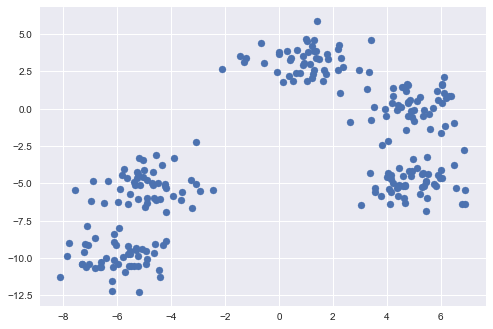

In [45]:
def get_data(n_clust = 3):
    X1 = np.random.normal(-5,1,50).reshape(-1,1)
    y1 = np.random.normal(-5,1,50).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,50).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(-10,10),1,50).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X

X = get_data(n_clust=5)
#np.random.shuffle(X)
plt.scatter(X[:,0],X[:,1]);

In [76]:
sc = spectral_clustering(k=5)
preds = sc.fit_predict(X)

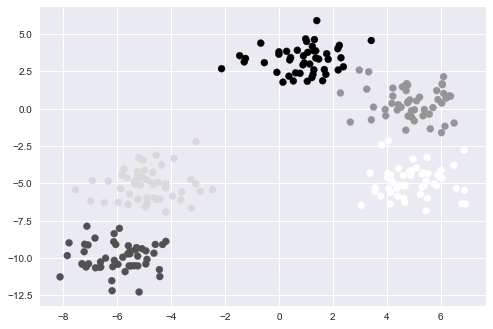

In [77]:
plt.scatter(X[:,0],X[:,1],c=preds);

Let's make sure this is working on new data. For my dataset (this will change if you re-run), the cluster around (-5,-5) is labeled as cluster 1. Let's see if a new point at (-5,-5) is put into cluster 1 correctly.

In [86]:
for x, y in zip(X[:10],preds[:10]):
    print("Point at: ", x)
    print("Cluster Num: ", y)
print("---")
print("At [-5, -5], should be same cluster.")
print("Prediction is: ",sc.predict([[-5,-5]]))

Point at:  [-4.96036149 -6.56631717]
Cluster Num:  [1]
Point at:  [-5.13329782 -5.10634174]
Cluster Num:  [1]
Point at:  [-6.97373174 -6.17872255]
Cluster Num:  [1]
Point at:  [-4.88609543 -5.96680606]
Cluster Num:  [1]
Point at:  [-3.60381859 -5.5722673 ]
Cluster Num:  [1]
Point at:  [-5.82273315 -4.43086164]
Cluster Num:  [1]
Point at:  [-4.46425185 -4.93953501]
Cluster Num:  [1]
Point at:  [-4.62819917 -5.97665151]
Cluster Num:  [1]
Point at:  [-6.47428161 -6.29349475]
Cluster Num:  [1]
Point at:  [-4.40859755 -6.03903678]
Cluster Num:  [1]
---
At [-5, -5], should be same cluster.
Prediction is:  [[1]]


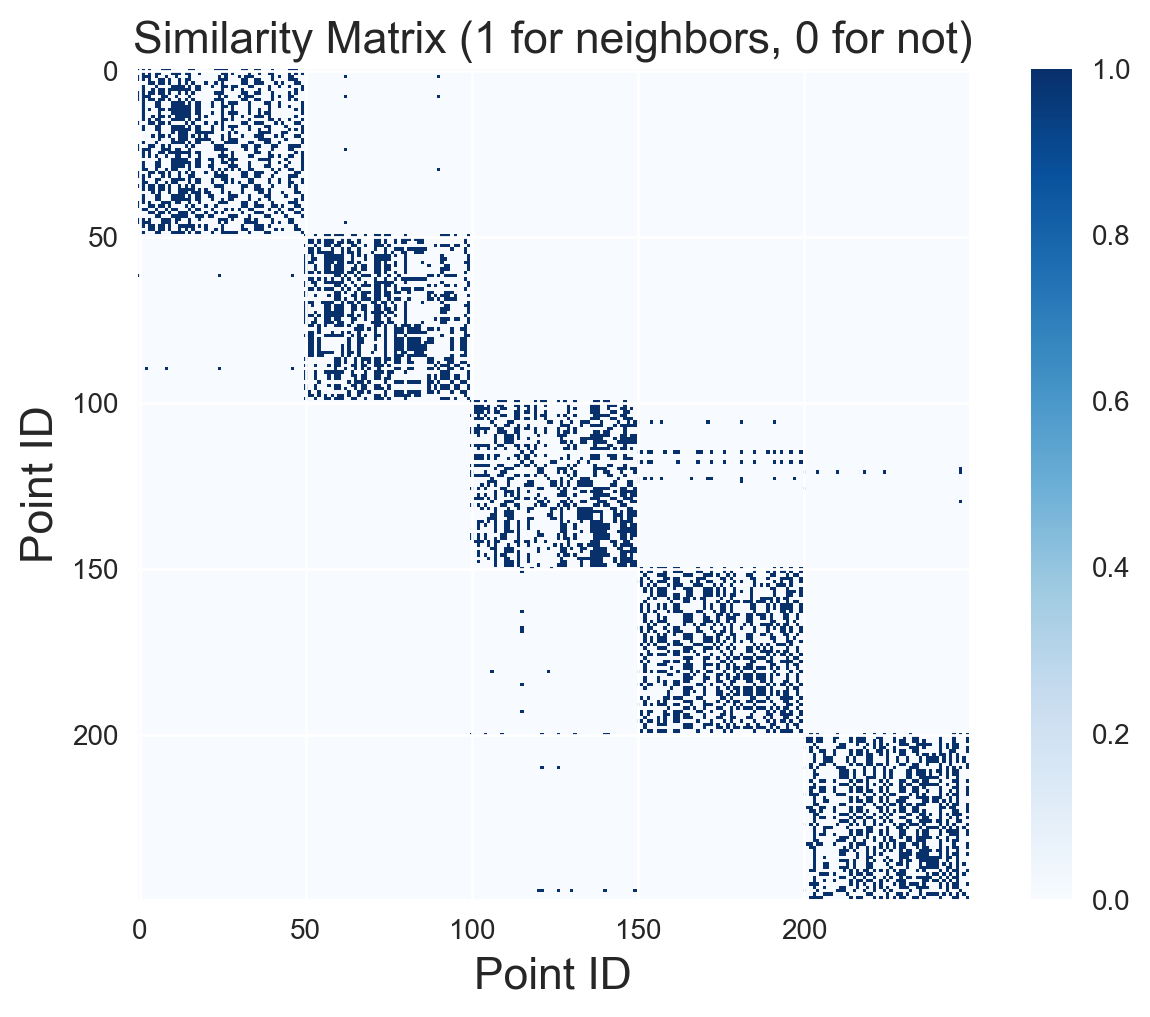

In [50]:
sc.plot_similarity_matrix()